In [1]:
import numpy as np
import pandas as pd
from string import ascii_lowercase
import re
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# from __future__ import print_function
# from keras.callbacks import ModelCheckpoint
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# from keras.layers import LSTM
# from keras.optimizers import RMSprop, Adam
# from keras.utils.data_utils import get_file

# import random
# import sys
# import io
# 
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)

Using TensorFlow backend.


In [3]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Pandas 1.0.1
Scikit-Learn 0.22.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [4]:
with open('LAMBADA/lambada_development_plain_text.txt', 'r', encoding='utf-8') as file:
    text = file.read().replace('\n', '').lower()

In [5]:
good_chars = list(ascii_lowercase)
good_chars.append(" ")
good_chars.append(".")
good_chars.append(",")
good_chars.append("'")

char_to_int = dict((c, i) for i, c in enumerate(good_chars))
int_to_char = dict((i, c) for i, c in enumerate(good_chars))

len(char_to_int)

30

### Extract relevant data

Uses the sliding door technique to create new dataframe. All lyrics are split into multiple segments of seed_len (40) characters each. These segments are saved into the new dataframe as a seed. The output is the next character in the lyrics.

For example, assume seed_len is 20 and lyric is "look at her face, its a wonderful face":
* "look at her face, it", 115 (unicode of "s" is 115)
* "ook at her face, its", 32 (unicode of " " is 32)
* "ok at her face, its ", 97 (unicode of "a" is 97)
* "k at her face, its a", 32 (unicode of " " is 32)
* " at her face, its a", 119 (unicode of "w" is 119)
* etc

In [6]:
# text = ''

# for i, row in songs['lyrics'].iteritems():
#     clean = str(row).lower().replace(' ', '\n')
#     text = text + " ".join(re.findall(r"[a-z']+", clean))

text_good = ['']

for c in text:
    if c in good_chars:
        text_good += c

text = ''.join(text_good)
len(text)

1637726

In [7]:
seed_len = 100
step = 1
seeds = []
outputs = []

for i in range(0, len(text) - seed_len, step):
    seeds.append(text[i: i + seed_len])
    outputs.append(text[i + seed_len])
    
len(seeds)

1637626

In [8]:
# from sklearn.utils import shuffle
seeds, outputs = shuffle(seeds, outputs, random_state=0)

print('Seed: ' + seeds[0])
print('Output: ' + outputs[0])

Seed: laced a shoe between the door and the wall to prevent it closing completely .  just in case we need 
Output: a


In [9]:
x = np.zeros((len(seeds), seed_len, len(good_chars)), dtype=np.bool)
y = np.zeros((len(seeds), len(good_chars)), dtype=np.bool)

for i, seed in enumerate(seeds):
    for t, char in enumerate(seed):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[outputs[i]]] = 1

## Building the AI

### Creating the model
Uses a Long-Short-Term-Memory (LSTM) network to predict the output from the seed.

In [10]:
# build the model: a single LSTM
# model = Sequential()
# model.add(LSTM(128, input_shape=(seed_len, len(good_chars))))
# model.add(Dense(len(good_chars)))
# model.add(Activation('softmax'))

# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01), metrics=['accuracy'])

model = Sequential()
model.add(LSTM(256, input_shape=(seed_len, len(good_chars))))
model.add(Dropout(0.2))
model.add(Dense(len(good_chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model = Sequential()
# model.add(LSTM(256, input_shape=(seed_len, len(good_chars)), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(256))
# model.add(Dropout(0.2))
# model.add(Dense(len(good_chars), activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               293888    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                7710      
Total params: 301,598
Trainable params: 301,598
Non-trainable params: 0
_________________________________________________________________


In [12]:
def read_prediction(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [13]:
train_len = int(x.shape[0] * 0.8)
test_len = int(x.shape[0] * 0.1)

x_train = x[:train_len, :, :]
y_train = y[:train_len, :]

x_val = x[train_len:train_len + test_len, :, :]
y_val = y[train_len:train_len + test_len, :]

x_test = x[train_len + test_len:, :, :]
y_test = y[train_len + test_len:, :]

In [14]:
# history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data = (x_val, y_val))
history = model.fit(x_train, y_train, epochs=6, batch_size=128, validation_data = (x_val, y_val))
# history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data = (x_val, y_va;))

Train on 1310100 samples, validate on 163762 samples
Epoch 1/6
1310100/1310100 [==============================] - 538s 411us/step - loss: 1.7828 - accuracy: 0.4700 - val_loss: 1.5208 - val_accuracy: 0.5410
Epoch 2/6
1310100/1310100 [==============================] - 536s 409us/step - loss: 1.4891 - accuracy: 0.5512 - val_loss: 1.4108 - val_accuracy: 0.5723
Epoch 3/6
1310100/1310100 [==============================] - 537s 410us/step - loss: 1.4074 - accuracy: 0.5746 - val_loss: 1.3603 - val_accuracy: 0.5887
Epoch 4/6
1310100/1310100 [==============================] - 535s 408us/step - loss: 1.3619 - accuracy: 0.5877 - val_loss: 1.3333 - val_accuracy: 0.5955
Epoch 5/6
1310100/1310100 [==============================] - 534s 408us/step - loss: 1.3316 - accuracy: 0.5959 - val_loss: 1.3153 - val_accuracy: 0.6003
Epoch 6/6
1310100/1310100 [==============================] - 534s 407us/step - loss: 1.3097 - accuracy: 0.6019 - val_loss: 1.3033 - val_accuracy: 0.6041


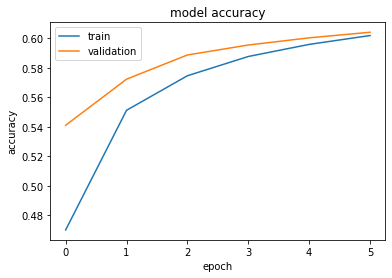

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

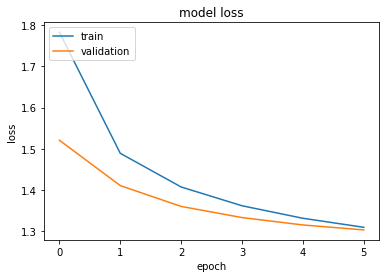

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def generate_output(size=400):
    generated = ''
    usr_input = input("Input a phrase to use for generation: ")

    seed = ('{0:0>' + str(seed_len) + '}').format(usr_input).lower()
    generated += usr_input 

    print("\n\nHere is your song: \n\n") 
    print(usr_input, end='')
    
    for i in range(size):
        x_pred = np.zeros((1, seed_len, len(good_chars)))

        for t, char in enumerate(seed):
            if char != '0':
                x_pred[0, t, char_to_int[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        output_index = read_prediction(preds, temperature = 0.2)
        output = int_to_char[output_index]

        generated += output
        seed = seed[1:] + output

        print(output, end='')

        if output == '\n':
            continue

In [ ]:
generate_output()

In [18]:
results = model.evaluate(x_test, y_test)

163764/163764 [==============================] - 55s 338us/step


In [19]:
results

[1.2925719225873398, 0.6067512035369873]